In [1]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy import stats
from scipy.integrate import quad
from scipy.interpolate import UnivariateSpline
import seaborn as sns
from scipy.special import factorial
import math
from iminuit import cost, Minuit 
import numpy as np

sns.set_context('talk', font_scale=1.0)
sns.set_palette('colorblind')

from depth_helpers import *

Cs_line = source_dict['Cs-137']

datpath = '/home/cosilab/CalibrationData/CalibratedDATs/'
plot_dir = '/home/cosilab/CalibrationData/figures/'
AC_illumination_CTD = '/home/cosilab/CalibrationData/CTDs/20231107_Am241_AC_prerad/CTD_parameters.txt'
DC_illumination_CTD = '/home/cosilab/CalibrationData/CTDs/20231107_Am241_DC_prerad/CTD_parameters.txt'
CTD_sims = '/home/cosilab/COSITrapping/ctd_sims/CTD_HP414183.csv'
AC_sim_events = '/home/cosilab/COSITrapping/ctd_sims/am241_interactions_HP414183_ac.csv'
DC_sim_events = '/home/cosilab/COSITrapping/ctd_sims/am241_interactions_HP414183_dc.csv'
sim_dCCE = '/home/cosilab/COSITrapping/cce_sims/HP414183_dCCE_1000cm.csv'

calibrator = DepthCalibrator_Am241(AC_illumination_CTD, DC_illumination_CTD, AC_sim_events, DC_sim_events, CTD_sims)
sim_depth, sim_ctd = calibrator.get_simdata()

# plt.figure()
# plt.hist(calibrator.AC_sim_CTD + np.random.normal(loc=0.0, scale=21.9, size=calibrator.AC_sim_CTD.shape), bins=100, label='Extra noise')
# plt.hist(calibrator.DC_sim_CTD + np.random.normal(loc=0.0, scale=19.6, size=calibrator.DC_sim_CTD.shape), bins=100, color='C0')
# plt.hist(calibrator.AC_sim_CTD + np.random.normal(loc=0.0, scale=12.0, size=calibrator.AC_sim_CTD.shape), bins=100, histtype='step', color='red', label='Original noise')
# plt.hist(calibrator.DC_sim_CTD + np.random.normal(loc=0.0, scale=12.0, size=calibrator.DC_sim_CTD.shape), bins=100, histtype='step', color='red')
# plt.legend()
# plt.xlabel('CTD (ns)')
# plt.ylabel('Counts')
# plt.tight_layout()
# plt.savefig(plot_dir + 'sim_CTD_noise_comparison.pdf')

21.8 +/- 1.9
19.3 +/- 1.7


# Same for after LL round 2

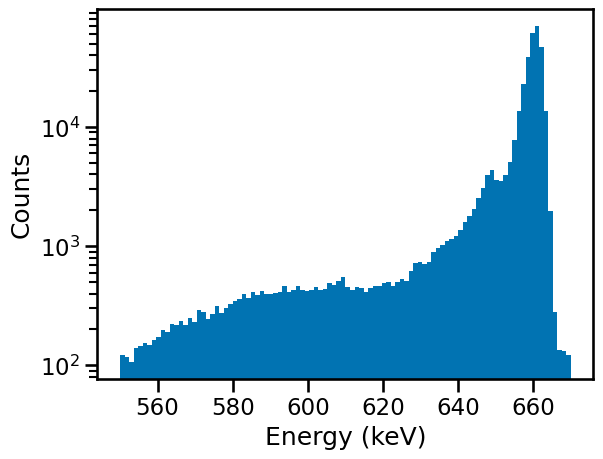

FWHM = 4.22
FWTM = 9.09


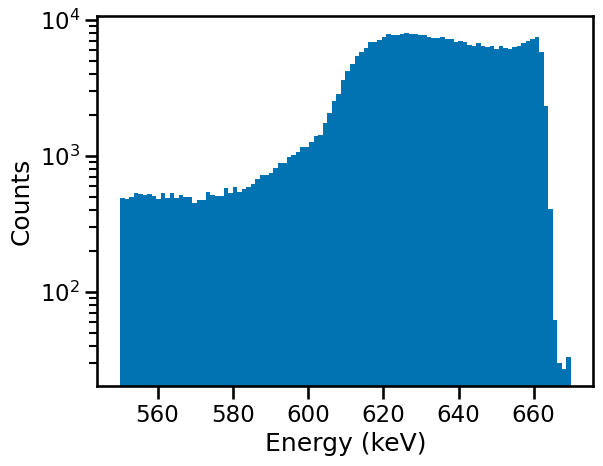

FWHM = 52.68
FWTM = 72.95


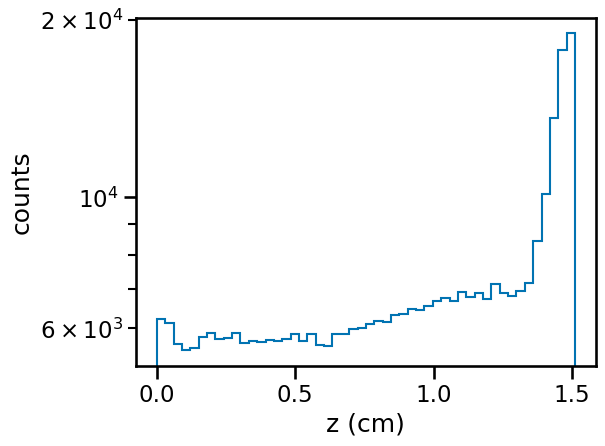

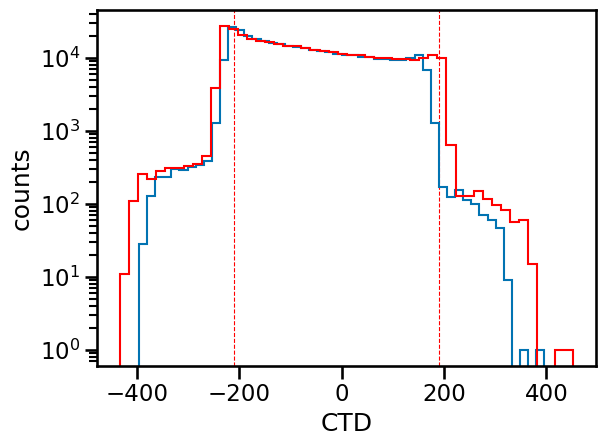

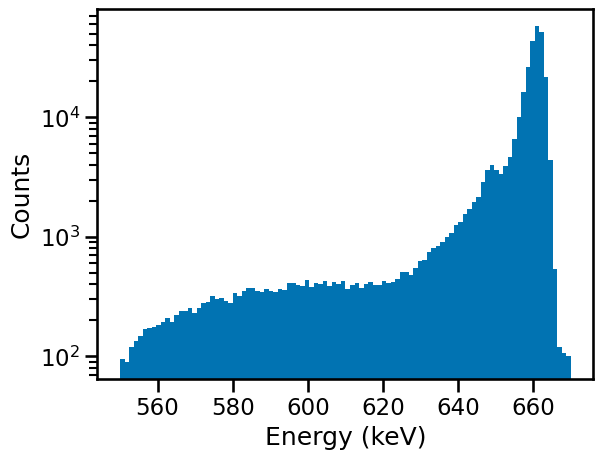

FWHM = 4.32
FWTM = 9.84


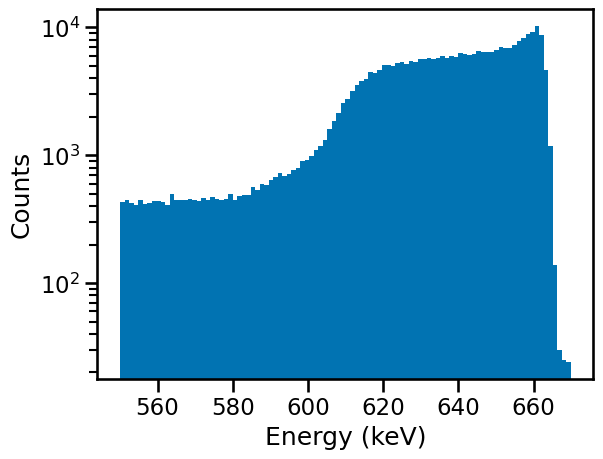

FWHM = 42.65
FWTM = 63.27


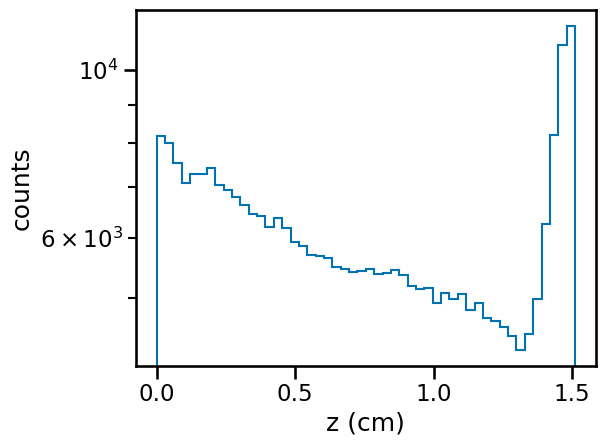

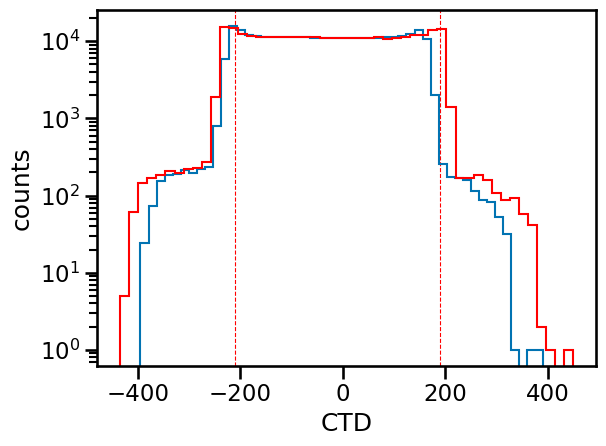

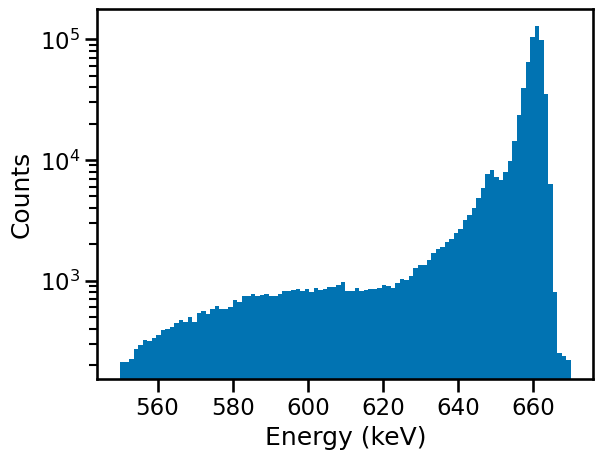

FWHM = 4.28
FWTM = 9.47


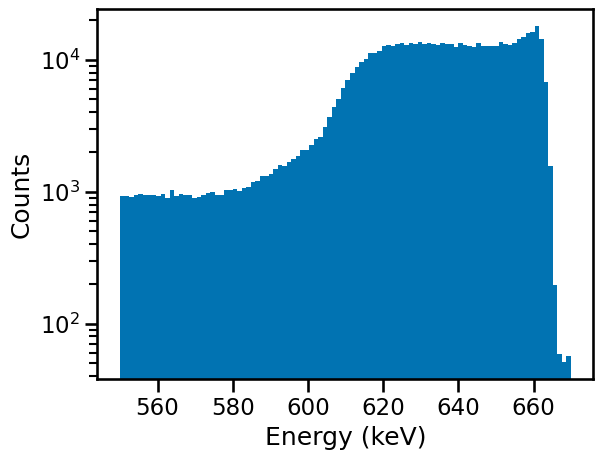

FWHM = 49.91
FWTM = 68.06


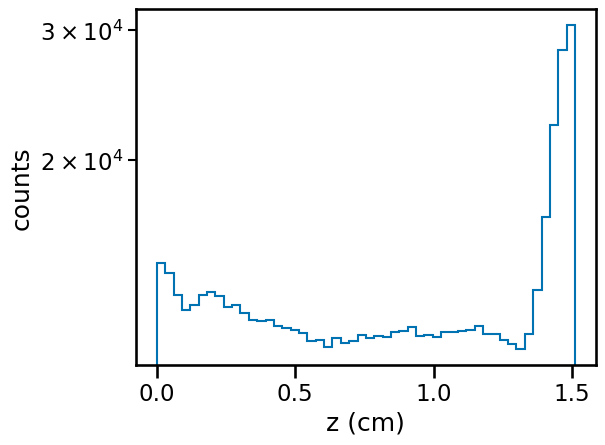

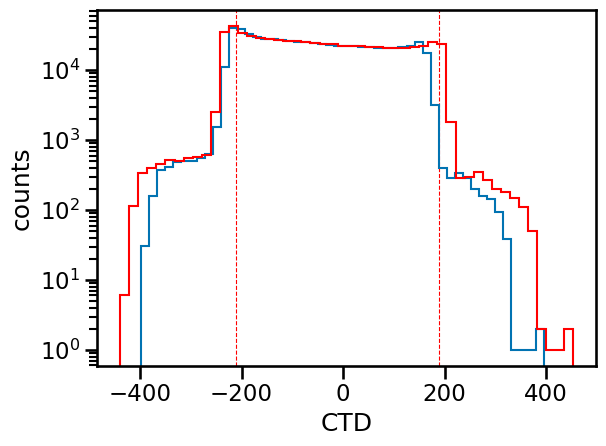

In [2]:
AC_list = ['20231120_Cs137_AC_600V.dat', '20231205_Cs137_AC_600V.dat', '20231208_Cs137_AC_600V.dat', '20231127_Cs137_AC_600V.dat', '20231206_Cs137_AC_600V.dat', '20231204_Cs137_AC_600V.dat', '20231207_Cs137_AC_600V.dat']
DC_list = ['20231122_Cs137_DC_600V.dat', '20231129_Cs137_DC_600V.dat', '20231201_Cs137_DC_600V.dat', '20231128_Cs137_DC_600V.dat', '20231130_Cs137_DC_600V.dat', '20231215_Cs137_DC_600V.dat']
allpaths = np.concatenate([AC_list, DC_list])
    
path_lists = [AC_list, DC_list, allpaths]
strings = ['allAC_postLL2', 'allDC_postLL2', 'allACandDC_postLL2']

emin = 550.
emax = 670.

df_list = []
    
for i in range(len(path_lists)):
    
    ## Read in the dat files
    fullpaths = []
    for p in path_lists[i]:
        fullpaths.append(datpath + 'postLL2/' + p)
    
    df = make_df_from_dat(fullpaths, e_min=emin, e_max=emax)

    plt.figure()
    hist,binedges,_  = plt.hist(df['energy_p'], bins=100)
    plt.yscale('log')
    plt.xlabel('Energy (keV)')
    plt.ylabel('Counts')
    plt.show()
    
    fwhm_spline = UnivariateSpline(binedges[:-1], hist-0.5*np.max(hist))
    fwtm_spline = UnivariateSpline(binedges[:-1], hist-0.1*np.max(hist))
    fwhm = fwhm_spline.roots()[-1]-fwhm_spline.roots()[0]
    fwtm = fwtm_spline.roots()[-1]-fwtm_spline.roots()[0]
    print('FWHM = ' + str(round(fwhm, 2)))
    print('FWTM = ' + str(round(fwtm, 2)))

    plt.figure()
    hist,binedges,_  = plt.hist(df['energy_n'], bins=100)
    plt.yscale('log')
    plt.xlabel('Energy (keV)')
    plt.ylabel('Counts')
    plt.show()
    
    fwhm_spline = UnivariateSpline(binedges[:-1], hist-0.5*np.max(hist))
    fwtm_spline = UnivariateSpline(binedges[:-1], hist-0.1*np.max(hist))
    fwhm = fwhm_spline.roots()[-1]-fwhm_spline.roots()[0]
    fwtm = fwtm_spline.roots()[-1]-fwtm_spline.roots()[0]
    print('FWHM = ' + str(round(fwhm, 2)))
    print('FWTM = ' + str(round(fwtm, 2)))

    ### Run depth calibration

    ctd_obs_map = [[[] for p in range(37)] for n in range(37)]
    ctd_stretch_map = [[[] for p in range(37)] for n in range(37)]
    ctd_obs_flat = []
    ctd_stretch_flat = []

    for p in range(37):
        for n in range(37):
            ctd_obs, ctd_stretch, depth, depth_err = calibrator.depth_from_timing_prob(p+1, n+1, df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'time_p'], \
                                                                                       df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'time_n'], \
                                                                                      df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'energy_p'])
            df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'z'] =  depth
            df.loc[df.strip_p.eq(p+1)&df.strip_n.eq(n+1), 'z_err'] =  depth_err
            ctd_obs_map[p][n] = ctd_obs
            ctd_stretch_map[p][n] = ctd_stretch
            ctd_obs_flat.append(ctd_obs)
            ctd_stretch_flat.append(ctd_stretch)

    ctd_obs_flat = np.concatenate(ctd_obs_flat)
    ctd_stretch_flat = np.concatenate(ctd_stretch_flat)
    df_list.append(df)
    
    plt.figure()
    plt.hist(df["z"], bins=50, histtype = "step", range=(calibrator.zmin,calibrator.zmax))
    plt.yscale('log')
    plt.xlabel("z (cm)")
    plt.ylabel("counts")
    plt.tight_layout()
    plt.savefig(plot_dir + 'Cs137_depth_' + strings[i] + '_prob.pdf')

    plt.figure()
    plt.hist(ctd_obs_flat, bins=50, histtype="step", label="Observed CTD")
    plt.hist(ctd_stretch_flat, bins=50, histtype="step", color='red', label="stretched and shifted")
    plt.axvline(np.max(sim_ctd), lw=0.8, color='red', ls='dashed', zorder=0)
    plt.axvline(np.min(sim_ctd), lw=0.8, color='red', ls='dashed', zorder=0)
    plt.yscale('log')
    plt.xlabel('CTD')
    plt.ylabel('counts')
    plt.tight_layout()
    plt.savefig(plot_dir + "Cs137_CTD_" + strings[i] + ".pdf")

z_list, e_signal_postLL2, h_signal_postLL2 = make_depthplot(df_list[-1], strings[-1], zmin=calibrator.zmin, zmax=calibrator.zmax)

In [3]:
depth_correction(df_list[-1], z_list, e_signal_postLL2, h_signal_postLL2, plot_suffix = 'Cs137allACandDC_postLL2')

FWHM = 4.28
FWTM = 9.47
FWHM = 3.81
FWTM = 8.47
FWHM = 49.91
FWTM = 68.06
FWHM = 7.72
FWTM = 21.5


,ID,det,strip_p,energy_p,time_p,strip_n,energy_n,time_n,x,y,z,z_err,z_binned,depth_corrected_energy_p,depth_corrected_energy_n
0,61,11,22,661.388388,150.0,28,628.711191,275.0,1.634266e+307,1.634266e+307,1.087870,0.046678,"(1.057, 1.107]",661.806304,666.527788
1,168,11,2,591.212232,185.0,9,580.030877,190.0,1.634266e+307,1.634266e+307,0.594384,0.040918,"(0.554, 0.604]",591.299476,595.710239
2,171,11,19,660.964171,165.0,28,624.604303,300.0,1.634266e+307,1.634266e+307,1.086675,0.047269,"(1.057, 1.107]",661.377939,662.124220
3,251,11,10,658.332789,240.0,25,654.350661,155.0,1.634266e+307,1.634266e+307,0.253495,0.034032,"(0.252, 0.302]",659.065640,659.668943
4,332,11,37,661.499646,220.0,20,651.214799,155.0,1.634266e+307,1.634266e+307,0.378978,0.035356,"(0.352, 0.403]",661.970945,660.585757
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
649925,4172506,11,6,657.863801,150.0,9,624.415785,370.0,1.634266e+307,1.634266e+307,1.480923,0.044804,"(1.46, 1.51]",660.743750,676.391241
649926,4172658,11,30,661.371904,235.0,34,655.766519,170.0,1.634266e+307,1.634266e+307,0.322106,0.034386,"(0.302, 0.352]",661.961781,663.265082
649927,4172683,11,25,660.438183,165.0,22,615.010424,355.0,1.634266e+307,1.634266e+307,1.314512,0.056404,"(1.309, 1.359]",661.965846,660.769914
649928,4172713,11,35,663.613850,160.0,8,636.828702,270.0,1.634266e+307,1.634266e+307,1.047844,0.046172,"(1.007, 1.057]",663.912838,673.427223


In [4]:
fit_CCE(z_list, e_signal_postLL2, h_signal_postLL2, sim_dCCE, plot_suffix = 'Cs137allACandDC_postLL2')

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 7.281e+04 (chi2/ndof = 1300.2)│              Nfcn = 302              │
│ EDM = 2.73e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ ae   │  664.724  │   0.004   │   -0.004   │   0.004    │         │         │       │
│ 1 │ b    │   2.281   │   0.006   │   -0.006   │   0.006    │    0    │         │       │
│ 2 │ c    │  28.140   │   0.005   │   -0.005   │   0.005    │    0    │         │       │
│ 3 │ ah   │  663.132  │   0.007   │   -0.007   │   0.007    │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌──────────┬───────────────────────┬───────────────────────┬───────────────────────┬───────────────────────┐
│          │          ae           │           b           │           c           │          ah           │
├──────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┼───────────┬───────────┤
│  Error   │  -0.004   │   0.004   │  -0.006   │   0.006   │  -0.005   │   0.005   │  -0.007   │   0.007   │
│  Valid   │   True    │   True    │   True    │   True    │   True    │   True    │   True    │   True    │
│ At Limit │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ Max FCN  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
│ New Min  │   False   │   False   │   False   │   False   │   False   │   False   │   False   │   False   │
└──────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┴───────────┘
┌────┬─────────────────────────────────────┐
│    │       ae        b        c       ah │
├────┼─────────────────────────────────────┤
│ ae │ 1.99e-05 1.91e-05 6.17e-06 9.24e-06 │
│  b │ 1.91e-05 3.38e-05 7.32e-06 1.16e-05 │
│  c │ 6.17e-06 7.32e-06 2.21e-05 2.94e-05 │
│ ah │ 9.24e-06 1.16e-05 2.94e-05 4.78e-05 │
└────┴─────────────────────────────────────┘